In this example we show how a CNN can be used to reconstruct an image from a sinogram using self-supervised learning. 
The CNN takes the original sinogram as an input and creates a filtered sinogram that is then back projected to yield a reconstructed image; this image then generates a sinogram (radon transform) that matches the original sinogram.
We are using only one sinogram here which is not fair; we should be using 1,000 - 10,000s of sinograms to see if the CNN can generalise and indeed learn to filter sinograms correctly

First we import all necessary modules

In [1]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import DCNN2D
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf


Check if Tensorflow will run on GPU

In [2]:

tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create a Shepp-Logan phantom

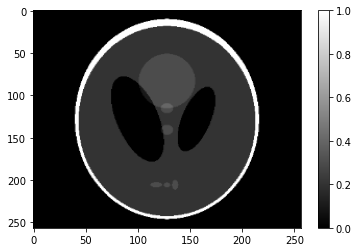

In [3]:
npix = 257
im = SheppLogan(npix)

showim(im, 1, cmap = 'gray')


Calculate the radon transform or sinogram

(1, 257, 257, 1)
(1, 257, 257, 1)


c:\programdata\anaconda3\lib\site-packages\tensorflow_addons\image\transform_ops.py:142: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  warnings.warn(


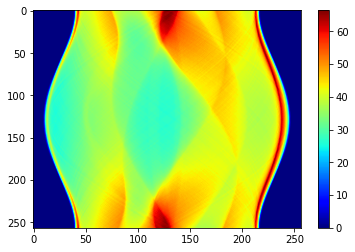

In [4]:
nproj = np.round(npix/1)
theta = tf_create_angles(nproj)

imtf = tf_tomo_transf(im)
print(imtf.shape)

sino = tf_tomo_radon(imtf, theta, interp_method='bilinear')
print(sino.shape)

showim(tf_tomo_squeeze(sino), 2)

Reconstruct using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (257, 257)


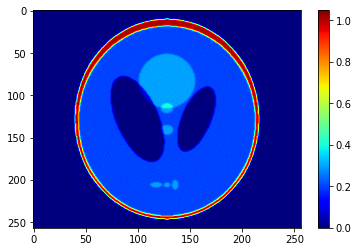

In [5]:
s = np.array(sino[0,:,:,0]).transpose()

fbp = fbpvol(s, theta=np.rad2deg(theta), nt = im.shape[0])
showim(fbp, 3, clim=(0, np.max(fbp)))

Let's create a 2D U-net CNN

In [8]:
model = DCNN2D(npix, npix, nlayers=3, net='unet', dropout='No', batchnorm = 'No', 
                filtnums=64, nconvs=3, actlayerfi = 'linear', skipcon = 'No', dlayer = 'No')

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 257, 257, 1) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 257, 257, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 257, 257, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 257, 257, 64) 36928       conv2d_24[0][0]                  
_______________________________________________________________________________________

Now we perform the training of the self-supervised CNN

In [7]:
epochs = 4001
save_interval = 100
lr_interval = 300

optimizer = tf.keras.optimizers.Adam(0.001)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(lr_interval/save_interval),
                                factor=0.5,
                                verbose=1, 
                                optim_lr=optimizer.learning_rate, 
                                reduce_lin=True)

loss = []

reduce_rl_plateau.on_train_begin()

kk = 1
for epoch in tqdm(range(epochs)):

    start = time.time()
    
    with tf.GradientTape(persistent=True) as tape:
        
        filtered_sino = model(sino)
        
        generated_img = tf_tomo_bp(filtered_sino, theta)

        generated_img = tf.abs(generated_img)
        
        gen_sino = tf_tomo_radon(generated_img, theta, tile=True)

        nnet_loss = ssim_mae_loss(tf.cast(sino, tf.float32), gen_sino)
                
    grad_nnet = tape.gradient(nnet_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad_nnet, model.trainable_variables))    
    
    loss.append(nnet_loss)

    if epoch % save_interval == 0 and epoch != 0:
            
        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, time.time() - start, nnet_loss))

        reduce_rl_plateau.on_epoch_end(kk, nnet_loss)
    
        kk = kk + 1



  3%|▎         | 102/4001 [00:13<06:20, 10.24it/s]

Time for epoch 1 to 100 is 0.09499788284301758 sec/it - gen_loss = 3.8881070613861084


  5%|▌         | 202/4001 [00:22<06:11, 10.22it/s]

Time for epoch 101 to 200 is 0.09849762916564941 sec/it - gen_loss = 2.1405036449432373


  8%|▊         | 302/4001 [00:32<05:56, 10.36it/s]

Time for epoch 201 to 300 is 0.09749913215637207 sec/it - gen_loss = 1.249549150466919


 10%|█         | 402/4001 [00:42<05:51, 10.23it/s]

Time for epoch 301 to 400 is 0.0989980697631836 sec/it - gen_loss = 1.070556640625


 13%|█▎        | 502/4001 [00:52<05:38, 10.34it/s]

Time for epoch 401 to 500 is 0.09449648857116699 sec/it - gen_loss = 1.0666968822479248


 15%|█▌        | 602/4001 [01:02<05:46,  9.81it/s]

Time for epoch 501 to 600 is 0.10399985313415527 sec/it - gen_loss = 1.0342307090759277


 18%|█▊        | 702/4001 [01:11<05:15, 10.45it/s]

Time for epoch 601 to 700 is 0.09799909591674805 sec/it - gen_loss = 1.0358134508132935


 20%|██        | 802/4001 [01:21<05:09, 10.35it/s]

Time for epoch 701 to 800 is 0.09809303283691406 sec/it - gen_loss = 1.212522029876709


 23%|██▎       | 902/4001 [01:31<04:57, 10.43it/s]

Time for epoch 801 to 900 is 0.09699773788452148 sec/it - gen_loss = 1.039473533630371

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


 25%|██▌       | 1002/4001 [01:40<04:47, 10.43it/s]

Time for epoch 901 to 1000 is 0.09599924087524414 sec/it - gen_loss = 0.7937206029891968


 28%|██▊       | 1102/4001 [01:50<04:41, 10.30it/s]

Time for epoch 1001 to 1100 is 0.09499692916870117 sec/it - gen_loss = 0.5547082424163818


 30%|███       | 1202/4001 [01:59<04:32, 10.26it/s]

Time for epoch 1101 to 1200 is 0.09541821479797363 sec/it - gen_loss = 1.5025001764297485


 33%|███▎      | 1302/4001 [02:09<04:21, 10.34it/s]

Time for epoch 1201 to 1300 is 0.09749794006347656 sec/it - gen_loss = 0.6100571155548096


 35%|███▌      | 1402/4001 [02:19<04:14, 10.22it/s]

Time for epoch 1301 to 1400 is 0.09849882125854492 sec/it - gen_loss = 0.7293471097946167

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 38%|███▊      | 1502/4001 [02:29<03:59, 10.44it/s]

Time for epoch 1401 to 1500 is 0.09510374069213867 sec/it - gen_loss = 0.42447328567504883


 40%|████      | 1602/4001 [02:38<03:50, 10.39it/s]

Time for epoch 1501 to 1600 is 0.09799718856811523 sec/it - gen_loss = 0.4145498275756836


 43%|████▎     | 1703/4001 [02:48<03:48, 10.04it/s]

Time for epoch 1601 to 1700 is 0.09649658203125 sec/it - gen_loss = 0.5162060856819153


 45%|████▌     | 1803/4001 [02:58<03:31, 10.41it/s]

Time for epoch 1701 to 1800 is 0.09357213973999023 sec/it - gen_loss = 0.5113875269889832


 48%|████▊     | 1903/4001 [03:07<03:19, 10.51it/s]

Time for epoch 1801 to 1900 is 0.09549736976623535 sec/it - gen_loss = 0.590482771396637

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 50%|█████     | 2003/4001 [03:17<03:11, 10.45it/s]

Time for epoch 1901 to 2000 is 0.09149932861328125 sec/it - gen_loss = 0.37166112661361694


 53%|█████▎    | 2103/4001 [03:27<03:05, 10.22it/s]

Time for epoch 2001 to 2100 is 0.09549999237060547 sec/it - gen_loss = 0.3656141459941864


 55%|█████▌    | 2203/4001 [03:36<02:54, 10.32it/s]

Time for epoch 2101 to 2200 is 0.09649920463562012 sec/it - gen_loss = 0.3617017865180969


 58%|█████▊    | 2303/4001 [03:46<02:43, 10.38it/s]

Time for epoch 2201 to 2300 is 0.09361577033996582 sec/it - gen_loss = 0.37109899520874023


 60%|██████    | 2403/4001 [03:56<02:34, 10.37it/s]

Time for epoch 2301 to 2400 is 0.09149885177612305 sec/it - gen_loss = 0.36481961607933044


 63%|██████▎   | 2503/4001 [04:05<02:24, 10.40it/s]

Time for epoch 2401 to 2500 is 0.09499931335449219 sec/it - gen_loss = 0.3728756010532379

Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


 65%|██████▌   | 2603/4001 [04:15<02:15, 10.32it/s]

Time for epoch 2501 to 2600 is 0.09449887275695801 sec/it - gen_loss = 0.35167041420936584


 68%|██████▊   | 2703/4001 [04:25<02:03, 10.52it/s]

Time for epoch 2601 to 2700 is 0.09399819374084473 sec/it - gen_loss = 0.3500822186470032


 70%|███████   | 2803/4001 [04:34<01:54, 10.48it/s]

Time for epoch 2701 to 2800 is 0.09166312217712402 sec/it - gen_loss = 0.34858280420303345


 73%|███████▎  | 2903/4001 [04:44<01:46, 10.29it/s]

Time for epoch 2801 to 2900 is 0.09799838066101074 sec/it - gen_loss = 0.3472837209701538


 75%|███████▌  | 3003/4001 [04:54<01:36, 10.39it/s]

Time for epoch 2901 to 3000 is 0.09499812126159668 sec/it - gen_loss = 0.34762176871299744


 78%|███████▊  | 3101/4001 [05:03<01:28, 10.22it/s]

Time for epoch 3001 to 3100 is 0.09564590454101562 sec/it - gen_loss = 0.34845447540283203


 80%|████████  | 3203/4001 [05:13<01:17, 10.36it/s]

Time for epoch 3101 to 3200 is 0.09749817848205566 sec/it - gen_loss = 0.3479442000389099

Epoch 00033: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


 83%|████████▎ | 3303/4001 [05:23<01:07, 10.35it/s]

Time for epoch 3201 to 3300 is 0.09799790382385254 sec/it - gen_loss = 0.3424614667892456


 85%|████████▌ | 3403/4001 [05:32<00:57, 10.39it/s]

Time for epoch 3301 to 3400 is 0.09250044822692871 sec/it - gen_loss = 0.3416975140571594


 88%|████████▊ | 3503/4001 [05:42<00:48, 10.31it/s]

Time for epoch 3401 to 3500 is 0.0944979190826416 sec/it - gen_loss = 0.34098923206329346


 90%|█████████ | 3603/4001 [05:51<00:38, 10.42it/s]

Time for epoch 3501 to 3600 is 0.09899759292602539 sec/it - gen_loss = 0.34022796154022217


 93%|█████████▎| 3703/4001 [06:01<00:28, 10.44it/s]

Time for epoch 3601 to 3700 is 0.09280228614807129 sec/it - gen_loss = 0.33944588899612427


 95%|█████████▌| 3803/4001 [06:11<00:18, 10.48it/s]

Time for epoch 3701 to 3800 is 0.09399843215942383 sec/it - gen_loss = 0.338643878698349


 98%|█████████▊| 3903/4001 [06:20<00:09, 10.41it/s]

Time for epoch 3801 to 3900 is 0.09652185440063477 sec/it - gen_loss = 0.33800458908081055


100%|██████████| 4001/4001 [06:30<00:00, 10.26it/s]

Time for epoch 3901 to 4000 is 0.09517836570739746 sec/it - gen_loss = 0.33774513006210327


Let's create now the CNN reconstructed image and compare it with the FBP algorithm

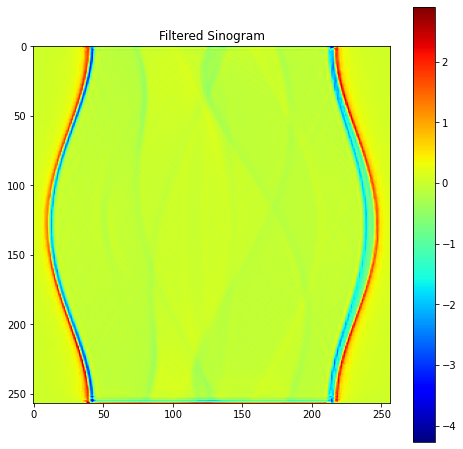

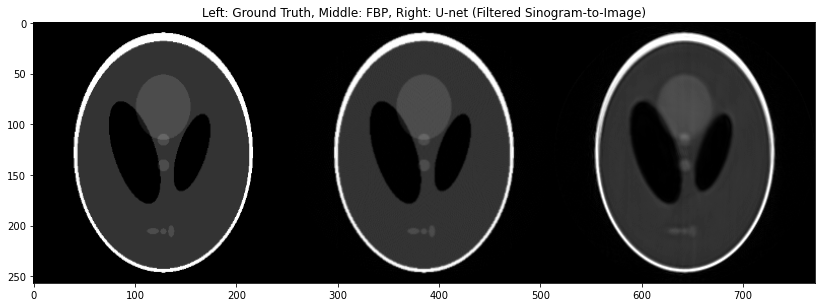

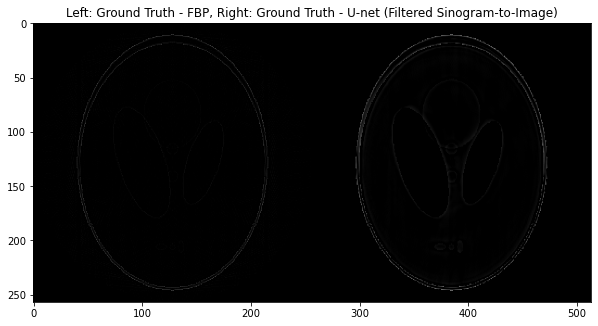

In [10]:
filtered_sino = model(sino)
generated_img = tf_tomo_bp(filtered_sino, theta)
generated_img = tf.abs(generated_img)
generated_img = tf_mask_circle(generated_img, npix=0)

plt.figure(1, figsize=(8,8));plt.clf()
plt.imshow(filtered_sino[0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('Filtered Sinogram')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: U-net (Filtered Sinogram-to-Image)')
plt.show()

plt.figure(3, figsize=(10,10));plt.clf()
plt.imshow(np.concatenate((im - fbp, im - generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth - FBP, Right: Ground Truth - U-net (Filtered Sinogram-to-Image)')
plt.show()

Let's calculate some metrics to compare the FBP and CNN reconstructions

In [11]:
imtf = np.reshape(im, (1, im.shape[0], im.shape[1],1))
imfbp = np.reshape(fbp, (1, fbp.shape[0], fbp.shape[1],1))

maeFBP = tf.reduce_mean(tf.keras.losses.MAE(im, fbp)).numpy()
maeCNN = tf.reduce_mean(tf.keras.losses.MAE(im, generated_img[0,:,:,0])).numpy()

mseFBP = tf.reduce_mean(tf.keras.losses.MSE(im, fbp)).numpy()
mseCNN = tf.reduce_mean(tf.keras.losses.MSE(im, generated_img[0,:,:,0])).numpy()

psnrFBP = tf.image.psnr(imtf, imfbp, 1).numpy()
psnrCNN = tf.image.psnr(imtf, generated_img, 1).numpy()

ssimFBP = tf.image.ssim(imtf, imfbp, 1).numpy()
ssimCNN = tf.image.ssim(imtf, np.array(generated_img, dtype='float64'), 1).numpy()

print(maeFBP, maeCNN)
print(mseFBP, mseCNN)
print(psnrFBP, psnrCNN)
print(ssimFBP, ssimCNN)


0.009661197566735464 0.014279475
0.0007830300505307404 0.0018270701
[31.062214] [27.382448]
[0.95534176] [0.8952836]
